In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OAM import OAMSorting as srt

### LG Modes

The versions used in these simulations are not exactly the LG modes - they are idealized versions where the radius of curvature is set to infinity and the Guoy phase is always zero. (In other words, I make the approximation that the beam divergence is negligible). 

$$u(r,\theta) \propto r^{|l|} \exp\left(-\frac{r^2}{w_0^2}\right)L_p^{|l|}\left(\frac{ 2 r^2}{w_0^2}\right) \exp\left(-il\theta\right)$$

Parameters:

$l$ is the helicity number. $p$ is the radial mode number. $w_0$ is the beam waist. 

### Unwrapper element
$$\phi_U = \frac{ka}{f}\left(r \theta\sin\theta + r\cos\theta\left(1 - \ln\frac{r}{b}\right)\right)$$

Parameters: 

$a$ scales the length of the transformed beam.

$b$ shifts the transformed beam in the $v$ direction (and is equivalent to the length of the needle, so it should be larger than the field of view of interest). 

$k$ is the wavenumber. $f$ is the focal length of the lens. 

### Corrector element

$$\phi_C = \frac{-kab}{f}\exp\left(-\frac{u}{a}\right)\cos\left(\frac{v}{a}\right)$$

The coordinates $u,v$ are in reciprocal space (after the first Fourier transforming lens) and are rescaled by $2\pi f/k$ in the code. 

### Overall setup:

The incoming electron has a quantized vorticity. The first element imparts the unwrapper phase on the electron, creating $\psi_U$. A lens Fourier transforms $\psi_U$ to give $\psi_{L1}$ in the back Fourier plane of the lens. In this plane, the second phase element imparts the corrector phase on the electron to create $\psi_C$. A second lens Fourier transforms this, giving $\psi_F$ which ideally should be a spot whose vertical direction depends linearly on the vorticity of the incident electron. 

\begin{align}
\psi_0 (x,y) & = u (r,\theta) \propto e^{i l \theta}
\\
\psi_U (x,y) & = \psi_0 e^{i\phi_U}
\\
\psi_{L1} (u,v) & \propto \mathscr{F}\{ \psi_U \}
\\
\psi_C (u,v) & \propto \psi_{L1} e^{i\phi_C}
\\
\psi_F (x,y) & \propto \mathscr{F}\{\psi_C\}
\end{align}

### Parameter choices

There are two main considerations when choosing parameter values. The first comes from the error introduced by OAM states to the coordinate transformation. The second comes from the limitations of FIB milling - there is a smallest periodicity that we can mill when we create the unwrapper and corrector phases. 

The first source of error comes from the fact that when we do the coordinate transformation, if the incident beam has a non-trivial phase structure, the actual coordinate transformation that gets implemented is different than what we want (see "Corrected Coordinate Transformation"). In particular, the actual coordinate transformation is: 

\begin{align}
u &= -a \ln\left(\frac{r}{b}\right) + \frac{lf}{kr}\sin\theta
\\
v &= a\theta - \frac{lf}{kr}\cos\theta
\end{align}

For this to be useful, it imposes the inequality:

\begin{equation}
\frac{lf}{kar} << 1
\end{equation}

The second restriction is on the pitch of the phase masks. This pitch is determined as $2\pi$ divided by the largest slope of the phase masks. After calculating the respective gradients and some algebraic manipulation, we find:

\begin{align}
a w_0 & >> \frac{\sqrt{2l}f}{k}
\\
\ln\left(\frac{r}{b}\right)^2 & < \left(\frac{2\pi f}{kad}\right)^2-\theta^2
\\
d & < \frac{2\pi f}{b k } e^{u/a}
\end{align}

Let's begin by assigning $a w_0 = \gamma \frac{\sqrt{2l}f}{k}$ where $l$ is the largest OAM mode you'd like to sort. Thus the second inequality can be rewritten

\begin{equation}
\ln\left(\frac{r}{b}\right)^2 < \left(\frac{2\pi w_0}{d\gamma\sqrt{2l}}\right)^2 - \pi^2
\end{equation}

Clearly, as $r \to 0$, this inequality will never hold. So let's begin by defining maximum and minimum radii for which these equations should hold. $r_{max}$ will be the radius of the unwrapper phase plate, so let's characterize it by $r_{max} = w_0 \sqrt{l_{max}/2}$ for some $l_{max}$ much larger than the OAM we'd like to sort. This is just to ensure the scale of the phase plate is correct for the incoming beam, whose waist we will determine now. Let's say we'd like the inequality above to hold down to some $r_{min} = w_0/(5\sqrt{2})$, somewhat arbitrarily; just, small enough that if the center of the phase plate is messed up, it won't affect the incoming beams too much. 

So, we need the inequality to hold for $w_0/(5\sqrt{2}) < r < w_0\sqrt{l_{max}/2}$. A bit of inequality plotting shows a good choice for $b$ is $b = r_{max}$. Then the LHS of the inequality is decreasing for all $r$ that we care about, so to determine a range for $w_0$ that will make it work, we should plug in $b$ and $r_{min}$ on the LHS, and solve for $w_0$. 

\begin{equation}
w_0 > \frac{d\gamma\sqrt{2l}}{2\pi}\sqrt{\ln(5\sqrt{l_{max}})^2+\pi^2}
\end{equation}

At this point, we have acceptable values:
\begin{align}
w_0 &> \frac{d\gamma\sqrt{2l}}{2\pi}\sqrt{\ln(5\sqrt{l_{max}})^2+\pi^2}
\\
a &= \gamma\frac{\sqrt{2l} f}{k w_0}
\\
b &= w_0 \sqrt{\frac{l_{max}}{2}}
\end{align}

Where for completeness: $\gamma >> 1$ determines the SPA error factor, $l$ is the largest OAM mode we'd practically like to sort, $l_{max}$ is just bookkeeping to determine the radius of the unwrapper phase plate, and $d$ is the minimum periodicity we can mill on said phase plate. 

In [2]:
l = 10; p = 0
a,b,w_0 = srt.genParams(l_sort=4,lmax=20,gamma=10)
sorter = srt.sorter(a,b)
sorter.coords(xymax=2*w_0*np.sqrt(l))
sorter.phaseElements()
sorter.characterize(w_0)
mode0 = srt.LG(sorter.X,sorter.Y,l=l,p=0,w_0=w_0)
mode1,mode2,mode3,mode4 = sorter.sort(mode0,atten=.3)

Incoming beam waist:  3.9782310849435074  um
Transformed beam height:  14.219521512719542  um
SPA error factor:  0.05
Min pitch, unwrapper:  135.25714244577006  nm
Min pitch, corrector:  158.7201152915714  nm
Spot separation:  140.6517088645335  nm


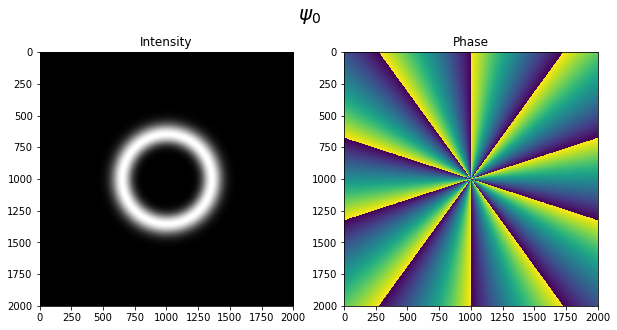

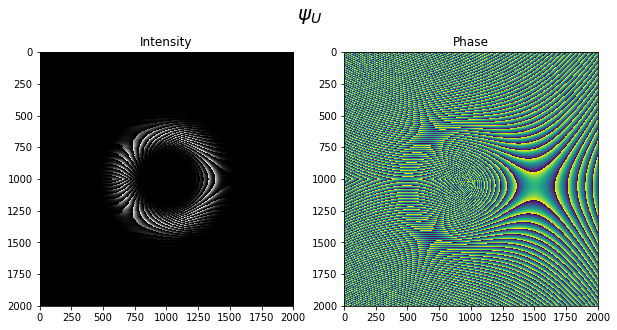

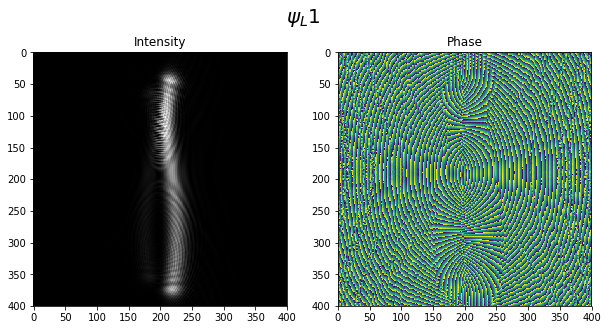

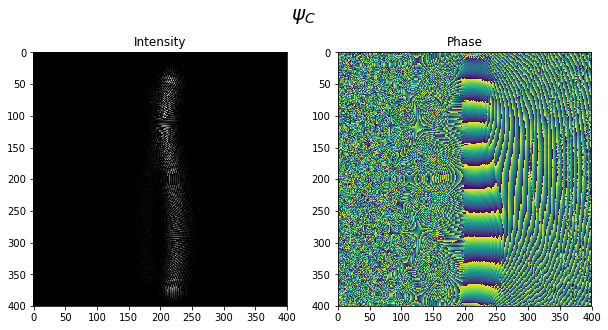

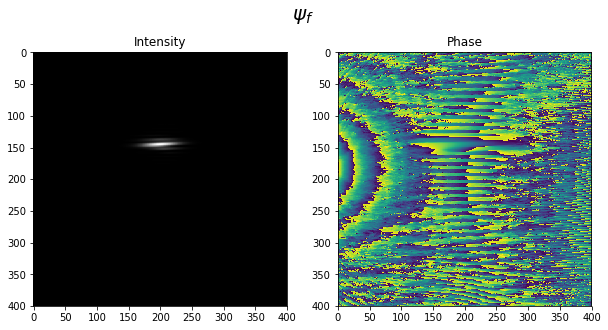

In [4]:
srt.plotIt(mode0,title="$\psi_0$")
srt.plotIt(mode1,title="$\psi_U$")
srt.plotIt(mode2,window=200,title="$\psi_L1$")
srt.plotIt(mode3,window=200,title="$\psi_C$")
srt.plotIt(mode4,window=200,title="$\psi_f$")